# Business Problem :

We are using Microsoft News Dataset for build a news recommendation system. The data is collected from anonymized behavior logs of Microsoft News Website.

# Data Overview :

Dataset : https://msnews.github.io/

The data contains 8 file in total i.e. 2 tsv and 2 pickle file for train dataset and 2 tsv and 2 pickle file for test dataset.

But for our model we will only be using 2 tsv file from train dataset and 2 tsv file from test dataset. i.e. :
1. behaviors.tsv
2. news.tsv


# Performace Metrics :

We will be using ROC-AUC Score as our evaluation metric, as we will be posing our ML model as classification problem.

# 1. Importing all the files and libraries

In [22]:
# importing all the important libraries
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

In [2]:
# loading news train dataset
df_news_train = pd.read_csv("MINDsmall_train/news.tsv", header=None, sep="\t")
df_news_train

,0,1,2,3,4,5,6,7
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[]


In [3]:
# renaming the columns for news train dataset
df_news_train = df_news_train.rename({0: 'News Id', 1: 'Category', 2: 'Subcategory', 3: 'Title', 4: 'Abstract', 5: 'Url', 
                                      6: 'Title Entities', 7: 'Abstract Entities'}, axis=1)
df_news_train.head()

,News Id,Category,Subcategory,Title,Abstract,Url,Title Entities,Abstract Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [4]:
# loading user train dataset
df_behaviors_train = pd.read_csv("MINDsmall_train/behaviors.tsv", header=None, sep="\t")
df_behaviors_train

,0,1,2,3,4
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...,...
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


In [5]:
# renaming the column for user train dataset
df_behaviors_train = df_behaviors_train.rename({0: 'Impression Id', 1: 'User Id', 2: 'Time', 3: 'History',
                                                4: 'Impression'}, axis=1)
df_behaviors_train.head()

,Impression Id,User Id,Time,History,Impression
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [6]:
# loading news test dataset
df_news_test = pd.read_csv("MINDsmall_dev/news.tsv", header=None, sep="\t")
df_news_test

,0,1,2,3,4,5,6,7
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
42411,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[]
42412,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida..."
42413,N30135,news,newsgoodnews,Tennessee judge holds lawyer's baby as he swea...,Tennessee Court of Appeals Judge Richard Dinki...,https://assets.msn.com/labs/mind/BBWyzI8.html,"[{""Label"": ""Tennessee"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Tennessee Court of Appeals"", ""Type..."
42414,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [7]:
# renaming the columns for news test dataset
df_news_test = df_news_test.rename({0: 'News Id', 1: 'Category', 2: 'Subcategory', 3: 'Title', 4: 'Abstract', 5: 'Url', 
                                    6: 'Title Entities', 7: 'Abstract Entities'}, axis=1)
df_news_test.head()

,News Id,Category,Subcategory,Title,Abstract,Url,Title Entities,Abstract Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [8]:
# loading user test dataset
df_behaviors_test = pd.read_csv("MINDsmall_dev/behaviors.tsv", header=None, sep="\t")
df_behaviors_test

,0,1,2,3,4
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...
...,...,...,...,...,...
73147,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...
73148,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...
73149,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...
73150,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...


In [9]:
# renaming the columns for user test dataset
df_behaviors_test = df_behaviors_test.rename({0: 'Impression Id', 1: 'User Id', 2: 'Time', 3: 'History',
                                              4: 'Impression'}, axis=1)
df_behaviors_test.head()

,Impression Id,User Id,Time,History,Impression
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


# 2. Data Cleaning

## 2.1. Checking Nan values

Remove Nan values in "History" column from both train and test

In [16]:
df_news_train.isna().sum()

News Id                 0
Category                0
Subcategory             0
Title                   0
Abstract             2666
Url                     0
Title Entities          3
Abstract Entities       4
dtype: int64

In [17]:
df_behaviors_train.isna().sum()

Impression Id       0
User Id             0
Time                0
History          3238
Impression          0
dtype: int64

In [18]:
df_news_test.isna().sum()

News Id                 0
Category                0
Subcategory             0
Title                   0
Abstract             2021
Url                     0
Title Entities          2
Abstract Entities       2
dtype: int64

In [19]:
df_behaviors_test.isna().sum()

Impression Id       0
User Id             0
Time                0
History          2214
Impression          0
dtype: int64

## 2.2. Dropping User Id having Null "History" Column

In [ ]:
# dropping rows having null history values from user train dataset
df_behaviors_train = df_behaviors_train.dropna()
df_behaviors_train.shape

In [ ]:
# dropping rows having null history values from user test dataset
df_behaviors_test = df_behaviors_test.dropna()
df_behaviors_test.shape

## 2.3. Removing extra Subcategory from test dataset

In [20]:
# checking subcategory which are present in train but not present in test dataset
test_subcategory_not_present_in_train = []
for i in list(set(df_news_test["Subcategory"].values)):
    if i not in list(set(df_news_train["Subcategory"].values)):
        test_subcategory_not_present_in_train.append(i)
        
test_subcategory_not_present_in_train

['lifestyleanimals',
 'newstechnology',
 'newsvideos',
 'games-news',
 'shop-computers-electronics',
 'lifestyletravel']

In [21]:
# dropping subcategory from test dataset which is not present in train dataset
print("Before Dropping df_news_test.shape :", df_news_test.shape)
for i in test_subcategory_not_present_in_train:
    df_news_test = df_news_test.drop(df_news_test[df_news_test["Subcategory"] == i].index, axis = 0)
print("After Dropping df_news_test.shape :", df_news_test.shape)

Before Dropping : (42416, 8)
After Dropping : (42410, 8)


# 3. EDA (Exploratory Data Analysis)

## 3.1 Analysis on News Category

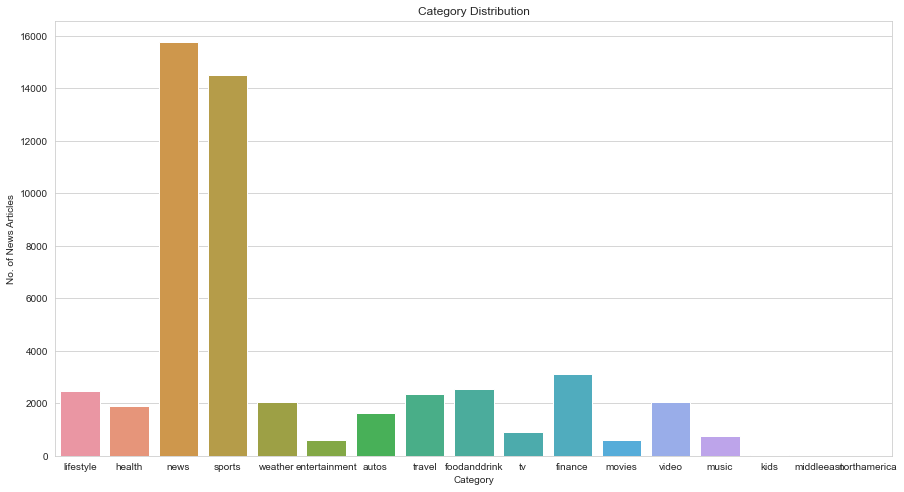

In [20]:
# plotting the distribution graph of News Category
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(df_news_train.Category)
plt.title('Category Distribution')
plt.xlabel('Category')
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6))
# ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('No. of News Articles')
plt.show()

## 3.2 Analysis on News Subcategory

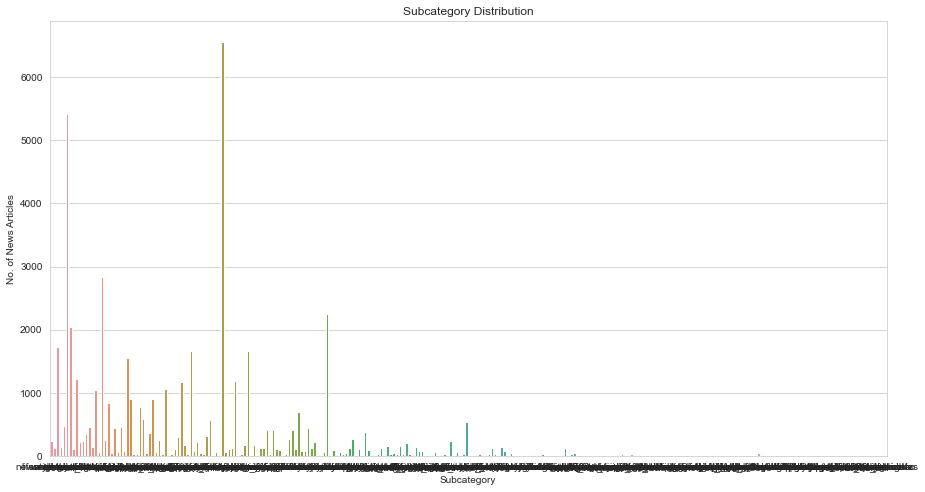

In [28]:
# plotting the distribution graph of News Subcategory
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(df_news_train.Subcategory)
plt.title('Subcategory Distribution')
plt.xlabel('Subcategory')
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6))
# ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('No. of News Articles')
plt.show()

In [29]:
# getting News Articles count for each subcategory
df_news_train["Subcategory"].value_counts()

newsus                    6564
football_nfl              5420
newspolitics              2826
newscrime                 2254
weathertopstories         2047
                          ... 
newsvideo                    1
travel                       1
lifestylehoroscopefish       1
baseball                     1
celebhub                     1
Name: Subcategory, Length: 264, dtype: int64

Text(0, 0.5, 'No. of News Articles')

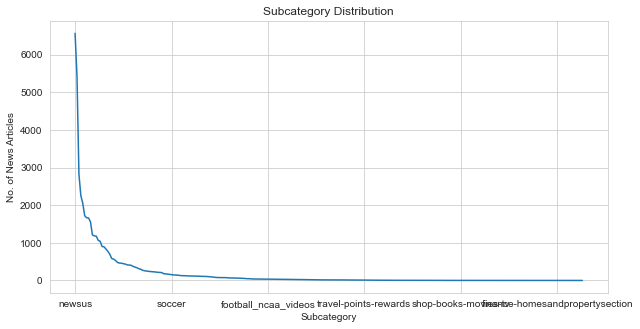

In [30]:
# plotting the distribution graph of News Subcategory
df_news_train["Subcategory"].value_counts().plot(figsize=(10,5), title = 'Subcategory Distribution')
plt.xlabel('Subcategory')
plt.ylabel('No. of News Articles')

## 3.3 Analysis of User Impression

In [33]:
# counting total 0 and 1 Impression
one_count = 0
zero_count = 0
for i in df_behaviors_train["Impression"].values:
    for j in i.split():
        if int(j[-1]) == 1:
            one_count += 1
        else:
            zero_count += 1
            
print("1-Impression Count :", one_count)
print("0-Impression Count :", zero_count)

1-Impression Count : 236344
0-Impression Count : 5607100


The 1-Impression is only approx 4% of the whole Impressions. We need to sample the data, as their are huge number of impressions. 

## 3.4 Analysing Cold Start Problem

## 3.4.1 User Cold Start Problem

In [36]:
user_id_train = df_behaviors_train["User Id"].values
user_id_test = df_behaviors_test["User Id"].values

user_not_present = 0
for i in tqdm(user_id_test):
    if i not in user_id_train:
        user_not_present += 1
        
print("Total number of user in Train Data :", len(user_id_train))
print("Total number of user in Test Data :", len(user_id_test))
print("Total number of New user for Train Data :", user_not_present)

100%|███████████████████████████████████████████████████████████████████████████| 73152/73152 [03:00<00:00, 406.20it/s]

Total number of user in Train Data : 156965
Total number of user in Test Data : 73152
Total number of New user for Train Data : 64193


## 3.4.2 News Cold Start Problem

In [37]:
news_id_train = df_news_train["News Id"].values
news_id_test = df_news_train["News Id"].values

news_not_present = 0
for i in tqdm(news_id_test):
    if i not in news_id_train:
        news_not_present += 1
        
print("Total number of news in Train Data :", len(news_id_train))
print("Total number of news in Test Data :", len(news_id_test))
print("Total number of New news for Train Data :", news_not_present)

100%|██████████████████████████████████████████████████████████████████████████| 51282/51282 [00:35<00:00, 1462.07it/s]

Total number of news in Train Data : 51282
Total number of news in Test Data : 51282
Total number of New news for Train Data : 0


# 4. Data Sampling

In [39]:
# sampling 10k users
df_unique_user_train_sample = df_unique_user_train.head(10000)
df_unique_user_train_sample.shape

(10000, 5)


In [40]:
# checking how many of the sampled user are present in test dataset
user_id_test_dict = dict()
for i in df_behaviors_test["User Id"].values:
    user_id_test_dict[i] = 0

present = []
for i in df_unique_user_train_sample["User Id"].values:
    if i in user_id_test_dict:
        present.append(i)
        
len(present)

1498


In [41]:
# storing sampled user history in the dictonary
sample_user_history_train_dict = dict()
sample_user_id = df_unique_user_train_sample["User Id"].values
sample_user_history = df_unique_user_train_sample["History"].values

for ind,i in enumerate(sample_user_id):
    sample_user_history_train_dict[i] = sample_user_history[ind].split()
    
# saving sample_user_history_train_dict in local folder
a_file = open('sample_user_history_train_dict', 'wb')
pickle.dump(sample_user_history_train_dict, a_file)
a_file.close()

# 5. Content Based Recommender System

## 5.1 Storing Sentence Embeddings of News Articles

In [21]:
# extracting sentence embedding of Title + Abstract for news articles in train dataset and storing it in dictonary
news_id_train = list(df_news_train["News Id"].values)
news_title_train = list(df_news_train["Title"].values)
news_abstract_train = list(df_news_train["Abstract"].values)

news_id_test = list(df_news_test["News Id"].values)
news_title_test = list(df_news_test["Title"].values)
news_abstract_test = list(df_news_test["Abstract"].values)

# loading pre trained sentence transformer model
sbert_model = SentenceTransformer('all-mpnet-base-v2')

news_embedding_vec_dict = dict()
news_title_embedding_vec_dict = dict()
news_abstract_embedding_vec_dict = dict()
for i in tqdm(range(len(news_id_train))):
    if news_abstract_train[i] == news_abstract_train[i]:
        news_embedding_vec_dict[news_id_train[i]] = sbert_model.encode(news_title_train[i] + ". " + news_abstract_train[i])
    else:
        news_embedding_vec_dict[news_id_train[i]] = sbert_model.encode(news_title_train[i])

100%|██████████████████████████████████████████████████████████████████████████| 51282/51282 [2:07:24<00:00,  6.71it/s]


In [63]:
# extracting sentence embedding of Title + Abstract for news articles only present in test dataset and storing it in dictonary
test_news_id_not_present_in_train = []
test_news_id_present_in_train = []
for i in tqdm(news_id_test):
    if i in news_embedding_vec_dict:
        test_news_id_present_in_train.append(i)
    else:
        test_news_id_not_present_in_train.append(i)
        
for i in tqdm(test_news_id_not_present_in_train):
    if news_abstract_test[news_id_test.index(i)] == news_abstract_test[news_id_test.index(i)]:
        news_embedding_vec_dict[i] = sbert_model.encode(news_title_test[news_id_test.index(i)] + ". " + news_abstract_test[news_id_test.index(i)])
    else:
        news_embedding_vec_dict[i] = sbert_model.encode(news_title_test[news_id_test.index(i)])

# saving news_embedding_vec_dict in local folder to import it later
a_file = open('news_embedding_vec_dict', 'wb')
pickle.dump(news_embedding_vec_dict, a_file)
a_file.close()

100%|██████████████████████████████████████████████████████████████████████████| 13956/13956 [1:01:20<00:00,  3.79it/s]


In [40]:
# storing news id corresponding to title, abstract, category, subcategory in different dictonary

news_category_train = list(df_news_train["Category"].values)
news_subcategory_train = list(df_news_train["Subcategory"].values)

news_category_test = list(df_news_test["Category"].values)
news_subcategory_test = list(df_news_test["Subcategory"].values)

# storing news data in dictonary for train dataset
news_title_dict = dict()
news_abstract_dict = dict()
news_category_dict = dict()
news_subcategory_dict = dict()
for ind,i in enumerate(news_id_train):
    news_title_dict[i] = news_title_train[ind]
    news_abstract_dict[i] = news_abstract_train[ind]
    news_category_dict[i] = news_category_train[ind]
    news_subcategory_dict[i] = news_subcategory_train[ind]

# storing news data in dictonary for news id only present in test dataset
for i in tqdm(test_news_id_not_present_in_train):
    ind = news_id_test.index(i)
    news_title_dict[i] = news_title_test[ind]
    news_abstract_dict[i] = news_abstract_test[ind]
    news_category_dict[i] = news_category_test[ind]
    news_subcategory_dict[i] = news_subcategory_test[ind]

# saving news_title_dict in local folder
a_file = open('news_title_dict', 'wb')
pickle.dump(news_title_dict, a_file)
a_file.close()

# saving news_abstract_dict in local folder
a_file = open('news_abstract_dict', 'wb')
pickle.dump(news_abstract_dict, a_file)
a_file.close()

# saving news_category_dict in local folder
a_file = open('news_category_dict', 'wb')
pickle.dump(news_category_dict, a_file)
a_file.close()

# saving news_subcategory_dict in local folder
a_file = open('news_subcategory_dict', 'wb')
pickle.dump(news_subcategory_dict, a_file)
a_file.close()

100%|██████████████████████████████████████████████████████████████████████████| 13950/13950 [00:05<00:00, 2546.43it/s]


## 5.2 Adding Categorical Features to News Embedding Vector

Adding Ctegorical Features like News Category and News Subcategory to News Embedding Vector

In [47]:
unique_category = list(set(news_category_train))
unique_subcategory = list(set(news_subcategory_train))

unique_category_and_subcategory = []
unique_category_and_subcategory.extend(unique_category)
unique_category_and_subcategory.extend(unique_subcategory)
unique_category_and_subcategory = list(set(unique_category_and_subcategory))

# getting unqiue category and subcategory
unique_category_and_subcategory_length = len(unique_category_and_subcategory)

# appending categorical features to news embedding vector for train dataset
news_embedding_and_categorical_vec_dict = dict()
for ind,i in tqdm(enumerate(news_id_train)):
    vec = news_embedding_vec_dict[i]
    cat_vec = np.zeros(unique_category_and_subcategory_length)
    cat_vec[unique_category_and_subcategory.index(news_category_train[ind])] = 1
    cat_vec[unique_category_and_subcategory.index(news_subcategory_train[ind])] = 1
    news_embedding_and_categorical_vec_dict[i] = np.append(vec, cat_vec) 
    
# appending categorical features to news embedding vector for news id only present in test dataset
for i in tqdm(test_news_id_not_present_in_train):
    vec = news_embedding_vec_dict[i]
    cat_vec = np.zeros(unique_category_and_subcategory_length)
    cat_vec[unique_category_and_subcategory.index(news_category_test[news_id_test.index(i)])] = 1
    cat_vec[unique_category_and_subcategory.index(news_subcategory_test[news_id_test.index(i)])] = 1
    news_embedding_and_categorical_vec_dict[i] = np.append(vec, cat_vec) 

# saving news_embedding_and_categorical_vec_dict in local folder
a_file = open('news_embedding_and_categorical_vec_dict', 'wb')
pickle.dump(news_embedding_and_categorical_vec_dict, a_file)
a_file.close()

51282it [00:02, 24375.47it/s]
100%|███████████████████████████████████████████████████████████████████████████| 13950/13950 [00:26<00:00, 526.21it/s]


## 5.3 Creating User Vector based on User History

Here we are creating user vector by Averaging the Vector of news present in user History.

In [74]:
# getting unique users history by dropping user id duplicate enteries as the History is same for given user
df_unique_user_train = df_behaviors_train.drop_duplicates(subset = ["User Id"], keep = 'first')
df_unique_user_train.shape

(49108, 5)

In [76]:
# creating user vector based on Users History and storing it in a dictonary
unique_user_id_train = df_unique_user_train["User Id"].values
unique_user_history_train = df_unique_user_train["History"].values

user_embedding_vec_train = dict()

for ind,i in tqdm(enumerate(unique_user_id_train)):
    user_vec = np.zeros(1042)
    user_history_list = unique_user_history_train[ind].split()
    for j in user_history_list:
        user_vec += news_embedding_and_categorical_vec_dict[j]
    user_vec = user_vec/len(user_history_list)
    user_embedding_vec_train[i] = user_vec
    
# saving user_embedding_vec_train in local folder
a_file = open('user_embedding_vec_train', 'wb')
pickle.dump(user_embedding_vec_train, a_file)
a_file.close()

49108it [00:03, 15005.34it/s]


## 5.4 Content Based Recommender System Model

In [19]:
def content_based_filtering(news_ids):
    
    a_file = open('news_embedding_and_categorical_vec_dict', 'rb')     
    news_embedding_and_categorical_vec_dict = pickle.load(a_file)
    a_file.close()
    
    a_file = open('news_title_dict', 'rb')     
    news_title_dict = pickle.load(a_file)
    a_file.close()
    
    a_file = open('news_abstract_dict', 'rb')     
    news_abstract_dict = pickle.load(a_file)
    a_file.close()
    
    a_file = open('news_category_dict', 'rb')     
    news_category_dict = pickle.load(a_file)
    a_file.close()
    
    a_file = open('news_subcategory_dict', 'rb')     
    news_subcategory_dict = pickle.load(a_file)
    a_file.close()
    
    news_id_list = list(news_embedding_and_categorical_vec_dict.keys())
    
    user_vec = np.zeros(1042)
    user_read_news_id_list = news_ids.split()
    for i in user_read_news_id_list:
        user_vec += news_embedding_and_categorical_vec_dict[i]
    user_vec = user_vec/len(user_read_news_id_list)
    
    user_read_news_id_dict = dict()
    for i in user_read_news_id_list:
        user_read_news_id_dict[i] = 0
    
    cos_sim_value_list = []
    user_unread_news_id_list = []
    for i in tqdm(news_id_list):
        if i not in user_read_news_id_dict:
            cos_sim_value_list.append(cosine_similarity(user_vec.reshape(1, -1), 
                                                        news_embedding_and_categorical_vec_dict[i].reshape(1, -1))[0][0])
            user_unread_news_id_list.append(i)
            
    df_sam = pd.DataFrame()
    df_sam["News Id"] = user_unread_news_id_list
    df_sam["Cos Sim Value"] = cos_sim_value_list
    df_sam = df_sam.sort_values(by='Cos Sim Value',ascending=False)
    
    top_rec_news_id = df_sam["News Id"].values[:10]
    
    top_title = []
    top_abstract = []
    top_category = []
    top_subcategory = []
    for i in top_rec_news_id:
        top_title.append(news_title_dict[i])
        top_abstract.append(news_abstract_dict[i])
        top_category.append(news_category_dict[i])
        top_subcategory.append(news_subcategory_dict[i])
    
    df_content_based_output = pd.DataFrame()
    df_content_based_output["News Id"] = top_rec_news_id
    df_content_based_output["Category"] = top_category
    df_content_based_output["Subcategory"] = top_subcategory
    df_content_based_output["Title"] = top_title
    df_content_based_output["Abstract"] = top_abstract
    
    history_title = []
    history_abstract = []
    history_category = []
    history_subcategory = []
    for i in user_read_news_id_list:
        history_title.append(news_title_dict[i])
        history_abstract.append(news_abstract_dict[i])
        history_category.append(news_category_dict[i])
        history_subcategory.append(news_subcategory_dict[i])
        
    df_history = pd.DataFrame()
    df_history["News Id"] = user_read_news_id_list
    df_history["Category"] = history_category
    df_history["Subcategory"] = history_subcategory
    df_history["Title"] = history_title
    df_history["Abstract"] = history_abstract
    
    return df_history, df_content_based_output

In [23]:
input_news_id = "N25567 N12440 N64498 N2073"
df_content_based_input, df_content_based_output = content_based_filtering(input_news_id)
df_content_based_output

100%|██████████████████████████████████████████████████████████████████████████| 65232/65232 [00:07<00:00, 8915.20it/s]


,News Id,Category,Subcategory,Title,Abstract
0,N36456,sports,football_nfl,NFL sending message with multiple fines for cr...,"It has not been a great week for NFL referees,..."
1,N36282,sports,football_nfl,NFL sending message with multiple fines for cr...,"It has not been a great week for NFL referees,..."
2,N36377,sports,football_nfl,NFL cracks down on internal dissent over offic...,The NFL threw yellow flags on Rams linebacker ...
3,N41309,movies,movievideo,Trailer - The Report,Trailer 2
4,N28811,movies,movievideo,Trailer - Scandalous,Official Trailer
5,N46502,sports,golf,2019-20 PGA Tour tournament winners,Check out all the winners on the PGA Tour in t...
6,N3051,sports,golf,"Another week, another rules controversy as Eur...",It is a good thing professional golf doesn't h...
7,N21157,movies,movievideo,Trailer - Full Count,Official Trailer
8,N53870,sports,golf,Controversy erupts at Pinehurst following rule...,"A rules violation, and how it was handled, at ..."
9,N64508,sports,football_nfl,NFL Reviewing Myles Garrett's Helmet Swing In ...,The late-game scuffle between the Cleveland Br...


In [24]:
df_content_based_input

,News Id,Category,Subcategory,Title,Abstract
0,N25567,movies,movies-celebrity,The Fast and the Furious Director Rob Cohen Ac...,A woman claims Cohen assaulted her in a hotel ...
1,N12440,movies,movievideo,Trailer - One Last Night,Official Trailer
2,N64498,sports,golf,PGA Tour winners,A gallery of recent winners on the PGA Tour.
3,N2073,sports,football_nfl,Should NFL be able to fine players for critici...,Several fines came down against NFL players fo...


# 6. Collaborative Based Recommender System

## 6.1 Creating User News Matrix

In [97]:
# creating dataframe of user id and correspondin read news id from the user history
user_id_train = df_unique_user_train_sample["User Id"].values
history_train = df_unique_user_train_sample["History"].values

new_user_id_train = []
new_news_id_train = []
new_value_train = []
for i in range(len(user_id_train)):
    x = history_train[i].split()
    new_news_id_train.extend(x)
    new_user_id_train.extend([user_id_train[i]]*len(x))
    new_value_train.extend([1]*len(x))
      
df_user_news_train = pd.DataFrame()
df_user_news_train["User Id"] = new_user_id_train
df_user_news_train["News Id"] = new_news_id_train
df_user_news_train["Value"] = new_value_train
df_user_news_train

,User Id,News Id,Value
0,U13740,N55189,1
1,U13740,N42782,1
2,U13740,N34694,1
3,U13740,N45794,1
4,U13740,N18445,1
...,...,...,...
291976,U83460,N12254,1
291977,U83460,N36615,1
291978,U83460,N16043,1
291979,U83460,N35671,1


In [98]:
# droping duplicates
df_user_news_train = df_user_news_train.drop_duplicates(subset = ["User Id", "News Id"], keep = 'first')
df_user_news_train.shape

(287806, 3)

In [99]:
# converting sample train dataframe to pivoted matrix dataframe with user id as rows and news id as columns
df_users_news_pivot_matrix = df_user_news_train.pivot(index='User Id', columns='News Id', values='Value').fillna(0)
df_users_news_pivot_matrix.head()

News Id,N100,N1000,N10001,N10003,N10009,N1001,N10014,N10016,N10021,N10024,...,N9967,N9969,N997,N9973,N9974,N9977,N9978,N9984,N9992,N9993
User Id,,,,,,,,,,,,,,,,,,,,,
U10022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# storing all the news id in sequence as per df_users_news_pivot_matrix dataframe
sample_news_id_train = list(df_users_news_pivot_matrix.columns) 

# storing all the user id in sequence as per df_users_news_pivot_matrix dataframe
sample_users_id_train = list(df_users_news_pivot_matrix.index)

users_news_matrix = df_users_news_pivot_matrix.astype(float)

# converting the sparse 'users_news_matrix' matrix to csr matrix
users_news_sparse_matrix = csr_matrix(users_news_matrix)
users_news_sparse_matrix

<10000x21954 sparse matrix of type '<class 'numpy.float64'>'
	with 287806 stored elements in Compressed Sparse Row format>

## 6.2 Decomposing User News Matrix

Decomposing User News Matrix using SVDs.

In [101]:
#The number of factors to factor the user-news matrix.
number_of_factor = 100
U, sigma, N = svds(users_news_sparse_matrix, k = number_of_factor)
sigma = np.diag(sigma)
print('The Shape of U, sigma and N are :')
print('U : ', U.shape)
print('sigma : ', sigma.shape)
print('N : ', N.shape)

The Shape of U, sigma and N are :
U :  (10000, 100)
sigma :  (100, 100)
N :  (100, 21954)


In [104]:
# getting user news matrix after decompostion of user news matrix
user_news_matrix_output = np.dot(U,N)
user_news_matrix_output.shape

(10000, 21954)

In [174]:
U_dict = dict()
N_dict = dict()

# getting transpose of News decomposition matrix
N_transpose = N.T

# storing User decomposition vector in dictonary
for ind,i in enumerate(sample_users_id_train):
    U_dict[i] = U[ind]
    
# storing News decomposition vector in dictonary
for ind,i in enumerate(sample_news_id_train):
    N_dict[i] = N_transpose[ind]
    
# saving U_dict in local folder
a_file = open('U_dict', 'wb')
pickle.dump(U_dict, a_file)
a_file.close()

# saving N_dict in local folder
a_file = open('N_dict', 'wb')
pickle.dump(N_dict, a_file)
a_file.close()

# saving user_news_matrix_output in local folder
a_file = open('user_news_matrix_output', 'wb')
pickle.dump(user_news_matrix_output, a_file)
a_file.close()

# saving sample_news_id_train in local folder
a_file = open('sample_news_id_train', 'wb')
pickle.dump(sample_news_id_train, a_file)
a_file.close()

# saving sample_users_id_train in local folder
a_file = open('sample_users_id_train', 'wb')
pickle.dump(sample_users_id_train, a_file)
a_file.close()

## 6.3 Collaborative Based Recommender System Model

In [139]:
def collaborative_filtering(user_id):
    
    # loading dictonary having news titles
    a_file = open('news_title_dict', 'rb')     
    news_title_dict = pickle.load(a_file)
    a_file.close()
    
    # loading dictonary having news abstract
    a_file = open('news_abstract_dict', 'rb')     
    news_abstract_dict = pickle.load(a_file)
    a_file.close()
    
    # loading dictonary having news category
    a_file = open('news_category_dict', 'rb')     
    news_category_dict = pickle.load(a_file)
    a_file.close()
    
    # loading dictonary having news subcategory
    a_file = open('news_subcategory_dict', 'rb')     
    news_subcategory_dict = pickle.load(a_file)
    a_file.close()
    
    # loading user_news_matrix_output matrix after decomposition
    a_file = open('user_news_matrix_output', 'rb')     
    user_news_matrix_output = pickle.load(a_file)
    a_file.close()
    
    # loading sample_news_id_train list
    a_file = open('sample_news_id_train', 'rb')     
    sample_news_id_train = pickle.load(a_file)
    a_file.close()
    
    # loading dictonary having sample user history
    a_file = open('sample_user_history_train_dict', 'rb')     
    sample_user_history_train_dict = pickle.load(a_file)
    a_file.close() 
    
    # storing user history in list
    user_history_title = []
    user_history_abstract = []
    user_history_category = []
    user_history_subcategory = []
    for i in sample_user_history_train_dict[user_id]:
        df_x = df_x.drop(df_x[df_x["News Id"] == i].index, axis = 0)
        user_history_title.append(news_title_dict[i])
        user_history_abstract.append(news_abstract_dict[i])
        user_history_category.append(news_category_dict[i])
        user_history_subcategory.append(news_subcategory_dict[i])
    
    # creating user history dataframe
    df_user_history = pd.DataFrame()
    df_user_history["News Id"] = sample_user_history_train_dict[user_id]
    df_user_history["Category"] = user_history_category
    df_user_history["Subcategory"] = user_history_subcategory
    df_user_history["Title"] = user_history_title
    df_user_history["Abstract"] = user_history_abstract
    
    # storing news id and corresponding values in dataframe
    df_x = pd.DataFrame()
    df_x["News Id"] = sample_news_id_train
    df_x["Value"] = user_news_matrix_output[sample_users_id_train.index(user_id)]
    df_x = df_x.sort_values(by='Value',ascending=False)
    
    # getting top 10 news id
    top_rec_news_id = df_x["News Id"].values[:10]
    
    # storing user output values in list
    top_title = []
    top_abstract = []
    top_category = []
    top_subcategory = []
    for i in top_rec_news_id:
        top_title.append(news_title_dict[i])
        top_abstract.append(news_abstract_dict[i])
        top_category.append(news_category_dict[i])
        top_subcategory.append(news_subcategory_dict[i])
    
    # creating user output dataframe
    df_collaborative_based_output = pd.DataFrame()
    df_collaborative_based_output["News Id"] = top_rec_news_id
    df_collaborative_based_output["Category"] = top_category
    df_collaborative_based_output["Subcategory"] = top_subcategory
    df_collaborative_based_output["Title"] = top_title
    df_collaborative_based_output["Abstract"] = top_abstract
    
    return df_user_history, df_collaborative_based_output

In [137]:
df_user_history, df_collaborative_based_output = collaborative_filtering("U10022")                                                                   
df_user_history

,News Id,Category,Subcategory,Title,Abstract
0,N39074,sports,more_sports,"Eliud Kipchoge runs 1:59 marathon, first to br...",Eliud Kipchoge became the first man to break t...
1,N879,sports,basketball_nba,Lakers and Nets players lost money on broken a...,"According to The Athletic's Shams Charania, pl..."
2,N11885,sports,football_nfl,Something fishy happened in that Texans-Chiefs...,"There was no pool report, no video from Al Riv..."
3,N20959,health,health-news,High school sports with highest concussion rat...,The rates of football practice concussions and...
4,N27448,sports,football_nfl,NFL world reacts to officials handing Packers ...,It's a regular occurrence for NFL officiating ...
5,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi..."
6,N14644,entertainment,celebrity,Charlize Theron & Margot Robbie Have Some Face...,"Star Tracks: Tuesday, October 15, 2019"
7,N16233,news,newsus,Felicity Huffman Is Scheduled to Be Released f...,Felicity Huffman's Release from Prison Set for...
8,N59649,sports,football_nfl,"If Jason Garrett would be in high demand, why ...","Twice this year, Cowboys owner Jerry Jones has..."
9,N8082,health,weightloss,Can Drinking Beer Wreck Your Weight-Loss Progr...,Maybe not: New research out of Spain shows tha...


In [138]:
df_collaborative_based_output

,News Id,Category,Subcategory,Title,Abstract
0,N55911,lifestyle,lifestylebuzz,Katie Holmes Talks About That Bra and Cardigan...,Katie Holmes Talks About That Bra and Cardigan...
1,N64467,news,newsus,Former Fox News hosts want out of non-disclosu...,"In the wake of the Me Too movement, women are ..."
2,N53531,tv,tv-celebrity,Lori Loughlin Is Facing New Charges in the Col...,Federal prosecutors brought new charges on Tue...
3,N53895,sports,football_nfl,Tom Brady explains why he's angry at this poin...,New England Patriots quarterback Tom Brady was...
4,N27526,news,newsus,"1 dead, 8 others hospitalized in Salmonella ou...",The CDC said the latest Salmonella outbreak is...
5,N40692,sports,football_nfl,Orlando Scandrick rips Eagles: They have 'acco...,Orlando Scandrick found himself released on Mo...
6,N40509,news,newscrime,One of FBI's Most Wanted fugitives offers surr...,One of the FBI's Most Wanted fugitives says he...
7,N42989,sports,more_sports,Eddy Merckx Hospitalized for Serious Head Inju...,The five-time Tour de France winner was injure...
8,N2735,sports,football_nfl,Jimmy Garoppolo addresses Erin Andrews intervi...,NaN
9,N59496,sports,football_nfl,"Week 7 winners, losers: Aaron Rodgers now in M...",Aaron Rodgers' big game vaults him into the MV...


# 7. Hybrid Recommender System

In Hybrid Recommender System we will be using both Conten Based Filtering and Collaborative Based Filtering Features to build multiple Machine Learning model. 

In [162]:
# creating impression dataframe for train dataset 

impression_news_id_list = []
impression_user_id_list = []
impression_list = []

for i in tqdm(sample_users_id_train):
    df_x = df_behaviors_train[df_behaviors_train["User Id"] == i]
    for j in df_x["Impression"].values:
        for k in j.split():
            x = k.split("-")
            impression_list.append(int(x[1]))
            impression_news_id_list.append(x[0])
            impression_user_id_list.append(i)
            
df_impression_train = pd.DataFrame()
df_impression_train["User Id"] = impression_user_id_list
df_impression_train["News Id"] = impression_news_id_list
df_impression_train["Score"] = impression_list
df_impression_train

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 140.11it/s]


,User Id,News Id,Score
0,U10022,N44698,0
1,U10022,N57733,0
2,U10022,N62563,0
3,U10022,N3415,0
4,U10022,N32015,0
...,...,...,...
1922156,U9991,N44249,0
1922157,U9991,N42670,1
1922158,U9991,N53470,0
1922159,U9991,N56211,0


In [188]:
# distribution of 0 and 1 in impression dataframe
df_impression_train["Score"].value_counts()

0    1841034
1      81127
Name: Score, dtype: int64

We can observer that the data is very imbalanced and the total data approximately equals to 2 Million.

As we do not have very system configuration we will have to sample the data.

So, we will be sampling the data for impression in train dataset and we will be sampling a balanced datset.

## 7.1 Data Sampling Data

### 7.1.1 Sampling Data for Train Dataset

In [190]:
impression_news_id_list = []
impression_user_id_list = []
impression_list = []

for i in tqdm(sample_users_id_train):
    df_x = df_behaviors_train[df_behaviors_train["User Id"] == i]
    for j in df_x["Impression"].values:
        one_imperssion_list = []
        one_impression_news_id_list = []
        one_impression_user_id_list = []
        
        zero_impression_list = []
        zero_impression_news_id_list = []
        zero_impression_user_id_list = []
        
        for k in j.split():
            x = k.split("-")
            if int(x[1]) == 1:
                one_imperssion_list.append(int(x[1]))
                one_impression_news_id_list.append(x[0])
                one_impression_user_id_list.append(i)
            elif int(x[1]) == 0:
                zero_impression_list.append(int(x[1]))
                zero_impression_news_id_list.append(x[0])
                zero_impression_user_id_list.append(i)
                
        if len(one_imperssion_list) > len(zero_impression_list):
            impression_list.extend(one_imperssion_list)
            impression_list.extend(zero_impression_list)
            
            impression_news_id_list.extend(one_impression_news_id_list)
            impression_news_id_list.extend(zero_impression_news_id_list)
            
            impression_user_id_list.extend(one_impression_user_id_list)
            impression_user_id_list.extend(zero_impression_user_id_list)
            
        else:
            l = len(one_imperssion_list)
            
            impression_list.extend(one_imperssion_list)
            impression_list.extend(zero_impression_list[:l])
            
            impression_news_id_list.extend(one_impression_news_id_list)
            impression_news_id_list.extend(zero_impression_news_id_list[:l])
            
            impression_user_id_list.extend(one_impression_user_id_list)
            impression_user_id_list.extend(zero_impression_user_id_list[:l])
            
df_impression_train = pd.DataFrame()
df_impression_train["User Id"] = impression_user_id_list
df_impression_train["News Id"] = impression_news_id_list
df_impression_train["Score"] = impression_list
df_impression_train

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 142.31it/s]


,User Id,News Id,Score
0,U10022,N38779,1
1,U10022,N29212,1
2,U10022,N44698,0
3,U10022,N57733,0
4,U10022,N61740,1
...,...,...,...
162225,U9991,N14436,1
162226,U9991,N42670,1
162227,U9991,N4162,0
162228,U9991,N10960,0


In [192]:
df_impression_train["Score"].value_counts()

1    81127
0    81103
Name: Score, dtype: int64

In [34]:
X_train = []
Y_train = list(df_impression_train["Score"].values)

for i in tqdm(range(len(impression_user_id_list))):
    user_id = impression_user_id_list[i]
    news_id = impression_news_id_list[i]
    if news_id in N_dict:
        vec = list(user_embedding_vec_train[user_id]) + list(U_dict[user_id]) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(N_dict[news_id])
    else:
        vec = list(user_embedding_vec_train[user_id]) + list(U_dict[user_id]) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(np.zeros(100))
    X_train.append(vec)
    
X_train = np.array(X_train)

a_file = open('X_train', 'wb')
pickle.dump(X_train, a_file)
a_file.close()

a_file = open('Y_train', 'wb')
pickle.dump(Y_train, a_file)
a_file.close()

X_train.shape

100%|█████████████████████████████████████████████████████████████████████████| 162230/162230 [03:06<00:00, 869.39it/s]


(162230, 2284)

### 7.1.2 Sampling Data for Overlapped Test Dataset

Here Overlapped Test Dataset means in this dataset all the users are present in the Test are present in Train Dataset.

In [63]:
# getting list of overlapped users
unique_user_id_test = list(set(df_behaviors_test["User Id"].values))

overlapped_user_id = []
new_user_id = []
for i in tqdm(unique_user_id_test):
    if i in sample_users_id_train:
        overlapped_user_id.append(i)
    else:
        new_user_id.append(i)
        
len(overlapped_user_id)

100%|██████████████████████████████████████████████████████████████████████████| 48593/48593 [00:04<00:00, 9839.61it/s]


1498

In [55]:
impression_news_id_list_overlapped = []
impression_user_id_list_overlapped = []
impression_list_overlapped = []

for i in tqdm(overlaped_user_id):
    df_x = df_behaviors_test[df_behaviors_test["User Id"] == i]
    for j in df_x["Impression"].values:
        one_imperssion_list = []
        one_impression_news_id_list = []
        one_impression_user_id_list = []
        
        zero_impression_list = []
        zero_impression_news_id_list = []
        zero_impression_user_id_list = []
        
        for k in j.split():
            x = k.split("-")
            if int(x[1]) == 1:
                one_imperssion_list.append(int(x[1]))
                one_impression_news_id_list.append(x[0])
                one_impression_user_id_list.append(i)
            elif int(x[1]) == 0:
                zero_impression_list.append(int(x[1]))
                zero_impression_news_id_list.append(x[0])
                zero_impression_user_id_list.append(i)
                
        if len(one_imperssion_list) > len(zero_impression_list):
            impression_list_overlapped.extend(one_imperssion_list)
            impression_list_overlapped.extend(zero_impression_list)
            
            impression_news_id_list_overlapped.extend(one_impression_news_id_list)
            impression_news_id_list_overlapped.extend(zero_impression_news_id_list)
            
            impression_user_id_list_overlapped.extend(one_impression_user_id_list)
            impression_user_id_list_overlapped.extend(zero_impression_user_id_list)
            
        else:
            l = len(one_imperssion_list)
            
            impression_list_overlapped.extend(one_imperssion_list)
            impression_list_overlapped.extend(zero_impression_list[:l])
            
            impression_news_id_list_overlapped.extend(one_impression_news_id_list)
            impression_news_id_list_overlapped.extend(zero_impression_news_id_list[:l])
            
            impression_user_id_list_overlapped.extend(one_impression_user_id_list)
            impression_user_id_list_overlapped.extend(zero_impression_user_id_list[:l])
            
df_impression_test_overlapped = pd.DataFrame()
df_impression_test_overlapped["User Id"] = impression_user_id_list_overlapped
df_impression_test_overlapped["News Id"] = impression_news_id_list_overlapped
df_impression_test_overlapped["Score"] = impression_list_overlapped
df_impression_test_overlapped

100%|█████████████████████████████████████████████████████████████████████████████| 1498/1498 [00:07<00:00, 188.89it/s]


,User Id,News Id,Score
0,U10045,N19611,1
1,U10045,N21681,1
2,U10045,N29862,0
3,U10045,N19990,0
4,U10062,N30290,1
...,...,...,...
8135,U9929,N23657,0
8136,U9929,N436,1
8137,U9929,N20477,1
8138,U9929,N14637,0


In [60]:
X_test_overlapped = []
Y_test_overlapped = list(df_impression_test_overlapped["Score"].values)

for i in tqdm(range(len(impression_user_id_list_overlapped))):
    user_id = impression_user_id_list_overlapped[i]
    news_id = impression_news_id_list_overlapped[i]
    if news_id in N_dict:
        vec = list(user_embedding_vec_train[user_id]) + list(U_dict[user_id]) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(N_dict[news_id])
    else:
        vec = list(user_embedding_vec_train[user_id]) + list(U_dict[user_id]) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(np.zeros(100))
    X_test_overlapped.append(vec)
    
X_test_overlapped = np.array(X_test_overlapped)

a_file = open('X_test_overlapped', 'wb')
pickle.dump(X_test_overlapped, a_file)
a_file.close()

a_file = open('Y_test_overlapped', 'wb')
pickle.dump(Y_test_overlapped, a_file)
a_file.close()

X_test_overlapped.shape

100%|████████████████████████████████████████████████████████████████████████████| 8140/8140 [00:04<00:00, 1878.67it/s]


(8140, 2284)

### 7.1.3 Sampling Data for Test Dataset having new Users

Here we are sampling data from test dataset such that it contains all the new users.

In [65]:
impression_news_id_list_new = []
impression_user_id_list_new = []
impression_list_new = []

for i in tqdm(new_user_id[:1500]):
    df_x = df_behaviors_test[df_behaviors_test["User Id"] == i]
    for j in df_x["Impression"].values:
        one_imperssion_list = []
        one_impression_news_id_list = []
        one_impression_user_id_list = []
        
        zero_impression_list = []
        zero_impression_news_id_list = []
        zero_impression_user_id_list = []
        
        for k in j.split():
            x = k.split("-")
            if int(x[1]) == 1:
                one_imperssion_list.append(int(x[1]))
                one_impression_news_id_list.append(x[0])
                one_impression_user_id_list.append(i)
            elif int(x[1]) == 0:
                zero_impression_list.append(int(x[1]))
                zero_impression_news_id_list.append(x[0])
                zero_impression_user_id_list.append(i)
                
        if len(one_imperssion_list) > len(zero_impression_list):
            impression_list_new.extend(one_imperssion_list)
            impression_list_new.extend(zero_impression_list)
            
            impression_news_id_list_new.extend(one_impression_news_id_list)
            impression_news_id_list_new.extend(zero_impression_news_id_list)
            
            impression_user_id_list_new.extend(one_impression_user_id_list)
            impression_user_id_list_new.extend(zero_impression_user_id_list)
            
        else:
            l = len(one_imperssion_list)
            
            impression_list_new.extend(one_imperssion_list)
            impression_list_new.extend(zero_impression_list[:l])
            
            impression_news_id_list_new.extend(one_impression_news_id_list)
            impression_news_id_list_new.extend(zero_impression_news_id_list[:l])
            
            impression_user_id_list_new.extend(one_impression_user_id_list)
            impression_user_id_list_new.extend(zero_impression_user_id_list[:l])
            
df_impression_test_new = pd.DataFrame()
df_impression_test_new["User Id"] = impression_user_id_list_new
df_impression_test_new["News Id"] = impression_news_id_list_new
df_impression_test_new["Score"] = impression_list_new
df_impression_test_new

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 280.59it/s]


,User Id,News Id,Score
0,U45507,N27738,1
1,U45507,N31958,0
2,U73859,N58656,1
3,U73859,N31958,0
4,U73859,N58251,1
...,...,...,...
6669,U70549,N41073,0
6670,U70549,N17031,0
6671,U70549,N496,0
6672,U70549,N36779,1


In [76]:
X_test_new = []
Y_test_new = []
test_score_new = list(df_impression_test_new["Score"].values)

for i in tqdm(impression_user_id_list_new):
    if i not in user_embedding_vec_train:
        vec = np.zeros(1042)
        history_list = df_behaviors_test[df_behaviors_test["User Id"] == i]["History"].values[0].split()
        for j in history_list:
            vec += news_embedding_and_categorical_vec_dict[j]
        vec = vec/len(history_list)
        user_embedding_vec_train[i] = vec

for i in tqdm(range(len(impression_user_id_list_new))):
    user_id = impression_user_id_list_new[i]
    news_id = impression_news_id_list_new[i]
    if news_id in news_embedding_and_categorical_vec_dict:
        if news_id in N_dict and user_id in U_dict:
            vec = list(user_embedding_vec_train[user_id]) + list(U_dict[user_id]) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(N_dict[news_id])
        elif news_id not in N_dict and user_id in U_dict:
            vec = list(user_embedding_vec_train[user_id]) + list(U_dict[user_id]) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(np.zeros(100))
        elif news_id in N_dict and user_id not in U_dict:
            vec = list(user_embedding_vec_train[user_id]) + list(np.zeros(100)) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(N_dict[news_id])
        else:
            vec = list(user_embedding_vec_train[user_id]) + list(np.zeros(100)) + list(news_embedding_and_categorical_vec_dict[news_id]) + list(np.zeros(100))
        X_test_new.append(vec)
        Y_test_new.append(test_score_new[i])
    
X_test_new = np.array(X_test_new)

a_file = open('X_test_new', 'wb')
pickle.dump(X_test_new, a_file)
a_file.close()

a_file = open('Y_test_new', 'wb')
pickle.dump(Y_test_new, a_file)
a_file.close()

X_test_new.shape

100%|████████████████████████████████████████████████████████████████████████████| 6674/6674 [00:00<00:00, 8326.26it/s]


(6673, 2284)

## 7.2 Machine Learning Models

Training various Machine Learning Models for Hybrid Recommender System.

In [26]:
# loading all the requried files to train a ML model
a_file = open('X_train', 'rb')     
X_train = pickle.load(a_file)
a_file.close()

a_file = open('Y_train', 'rb')     
Y_train = pickle.load(a_file)
a_file.close()


a_file = open('X_test_overlapped', 'rb')     
X_test_overlapped = pickle.load(a_file)
a_file.close()

a_file = open('Y_test_overlapped', 'rb')     
Y_test_overlapped = pickle.load(a_file)
a_file.close()


a_file = open('X_test_new', 'rb')     
X_test_new = pickle.load(a_file)
a_file.close()

a_file = open('Y_test_new', 'rb')     
Y_test_new = pickle.load(a_file)
a_file.close()

In [27]:
print("X_train shape :", X_train.shape)
print("X_test_overlapped shape :", X_test_overlapped.shape)
print("X_test_new shape :", X_test_new.shape)

X_train shape : (162230, 2284)
X_test_overlapped shape : (8140, 2284)
X_test_new shape : (6673, 2284)


# 7.2.1 Logistic Regression

In [2]:
# Training Logistic Regression Model and finding Roc AUC Score
log_reg = LogisticRegression(random_state=0).fit(X_train, Y_train)

# computing roc auc score for train, test overlapped and test new datapoint
roc_auc_score_train = roc_auc_score(Y_train, log_reg.predict_proba(X_train)[:, 1])
roc_auc_score_test_overlapped = roc_auc_score(Y_test_overlapped, log_reg.predict_proba(X_test_overlapped)[:, 1])
roc_auc_score_test_new = roc_auc_score(Y_test_new, log_reg.predict_proba(X_test_new)[:, 1])

print("Train ROC-AUC Score :", roc_auc_score_train)
print("Overlapped Test ROC-AUC Score :", roc_auc_score_test_overlapped)
print("New Test ROC-AUC Score :", roc_auc_score_test_new)

Train ROC-AUC Score : 0.6699649149155638
Overlapped Test ROC-AUC Score : 0.5727784351248725
New Test ROC-AUC Score : 0.5659893272076975


# 7.2.2 KNN

In [5]:
# finding the best parameter for KNN model with the help of GridSearchCV
knn = KNeighborsClassifier(n_jobs = -1)
params = {'n_neighbors' : [3,7,11,15,21,25]}
grid_search = GridSearchCV(knn, param_grid = params, scoring = make_scorer(roc_auc_score, greater_is_better=True), 
                           cv = 3, n_jobs = -1)
grid_search.fit(X_train, Y_train)
print('Best Params: ', grid_search.best_params_)

Best Params:  {'n_neighbors': 15}


In [6]:
# Training KNN Model and finding Roc AUC Score
knn = KNeighborsClassifier(n_neighbors = 15, n_jobs = -1)
knn.fit(X_train, Y_train)

# computing roc auc score for train, test overlapped and test new datapoint
roc_auc_score_train = roc_auc_score(Y_train, knn.predict_proba(X_train)[:, 1])
roc_auc_score_test_overlapped = roc_auc_score(Y_test_overlapped, knn.predict_proba(X_test_overlapped)[:, 1])
roc_auc_score_test_new = roc_auc_score(Y_test_new, knn.predict_proba(X_test_new)[:, 1])

print("Train ROC-AUC Score :", roc_auc_score_train)
print("Overlapped Test ROC-AUC Score :", roc_auc_score_test_overlapped)
print("New Test ROC-AUC Score :", roc_auc_score_test_new)

Train ROC-AUC Score : 0.7410160399280021
Overlapped Test ROC-AUC Score : 0.6223583903313632
New Test ROC-AUC Score : 0.6162082320957738


# 7.2.3 Linear SVC

In [7]:
# finding the best parameter for Linear SVC model with the help of GridSearchCV
params = {'C' : [0.001, 0.01, 0.1, 1, 10, 100]}
svc = LinearSVC(random_state = 42)
grid_search = GridSearchCV(svc, param_grid = params, scoring = make_scorer(roc_auc_score, greater_is_better = True), 
                           cv = 3, n_jobs = -1)
grid_search.fit(X_train, Y_train)
print('Best Params: ', grid_search.best_params_)

Best Params:  {'C': 0.01}


In [8]:
# Training Linear SVC Model and finding Roc AUC Score
svc = LinearSVC(C = 0.01, random_state = 42)
svc.fit(X_train, Y_train)

# computing roc auc score for train, test overlapped and test new datapoint
roc_auc_score_train = roc_auc_score(Y_train, svc.predict_proba(X_train)[:, 1])
roc_auc_score_test_overlapped = roc_auc_score(Y_test_overlapped, svc.predict_proba(X_test_overlapped)[:, 1])
roc_auc_score_test_new = roc_auc_score(Y_test_new, svc.predict_proba(X_test_new)[:, 1])

print("Train ROC-AUC Score :", roc_auc_score_train)
print("Overlapped Test ROC-AUC Score :", roc_auc_score_test_overlapped)
print("New Test ROC-AUC Score :", roc_auc_score_test_new)

Train ROC-AUC Score : 0.6116601615011634
Overlapped Test ROC-AUC Score : 0.5484029484029483
New Test ROC-AUC Score : 0.5555243997789482


# 7.2.4 Decision Tree

In [9]:
# finding the best parameter for Decision Tree model with the help of RandomizedSearchCV
params = {"max_depth" : [1, 10, 50, 100, 500], 
          "min_samples_split" : [5, 10, 100, 500]}
decision_tree = DecisionTreeClassifier(random_state = 42)
random_search = RandomizedSearchCV(decision_tree, param_distributions = params, 
                                   scoring = make_scorer(roc_auc_score, greater_is_better = True), cv = 3, n_jobs = -1)
random_search.fit(X_train, Y_train)
print('Best Params: ', random_search.best_params_) 

Best Params:  {'min_samples_split': 500, 'max_depth': 500}


In [10]:
# Training Decision Tree Model and finding Roc AUC Score
decision_tree = DecisionTreeClassifier(max_depth = 500, min_samples_split = 500, random_state = 0)
decision_tree.fit(X_train, Y_train)

# computing roc auc score for train, test overlapped and test new datapoint
roc_auc_score_train = roc_auc_score(Y_train, decision_tree.predict_proba(X_train)[:, 1])
roc_auc_score_test_overlapped = roc_auc_score(Y_test_overlapped, decision_tree.predict_proba(X_test_overlapped)[:, 1])
roc_auc_score_test_new = roc_auc_score(Y_test_new, decision_tree.predict_proba(X_test_new)[:, 1])

print("Train ROC-AUC Score :", roc_auc_score_train)
print("Overlapped Test ROC-AUC Score :", roc_auc_score_test_overlapped)
print("New Test ROC-AUC Score :", roc_auc_score_test_new)

Train ROC-AUC Score : 0.6974935570212547
Overlapped Test ROC-AUC Score : 0.5398438565883283
New Test ROC-AUC Score : 0.5568349186398559


# 7.2.5 LightGBM

In [11]:
# finding the best parameter for LightGBM with the help of RandomizedSearchCV
params = {"max_depth" : [1, 10, 50, 100, 500], 
          "n_estimators" : [5, 10, 100, 500]}
lgbm = LGBMClassifier(n_jobs = -1, random_state = 42)
random_search = RandomizedSearchCV(lgbm, param_distributions = params, 
                                   scoring = make_scorer(roc_auc_score, greater_is_better = True), n_jobs = -1)
random_search.fit(X_train, Y_train)
print('Best Params : ', random_search.best_params_) 

Best Params :  {'n_estimators': 500, 'max_depth': 500}


In [14]:
# Training LightGBM Model and finding Roc AUC Score
lgbm = LGBMClassifier( n_jobs = -1, max_depth = 500,random_state = 42, n_estimators = 500)
lgbm.fit(X_train, Y_train)

# computing roc auc score for train, test overlapped and test new datapoint
roc_auc_score_train = roc_auc_score(Y_train, lgbm.predict_proba(X_train)[:, 1])
roc_auc_score_test_overlapped = roc_auc_score(Y_test_overlapped, lgbm.predict_proba(X_test_overlapped)[:, 1])
roc_auc_score_test_new = roc_auc_score(Y_test_new, lgbm.predict_proba(X_test_new)[:, 1])

print("Train ROC-AUC Score :", roc_auc_score_train)
print("Overlapped Test ROC-AUC Score :", roc_auc_score_test_overlapped)
print("New Test ROC-AUC Score :", roc_auc_score_test_new)

Train ROC-AUC Score : 0.8977872718884597
Overlapped Test ROC-AUC Score : 0.5941267076770762
New Test ROC-AUC Score : 0.5924488907525463


# 8. Conclusion

In [18]:
from prettytable import PrettyTable

myTable_hybrid_model = PrettyTable(["Machine Learning Models", "Train ROC-AUC Score", "Overlapped Test ROC-AUC Score", "New Test ROC-AUC Score"])
# adding rows
myTable_hybrid_model.add_row(["Logistic Regression", "0.6699", "0.5727", "0.5659"])
myTable_hybrid_model.add_row(["KNN", "0.7410", "0.6223", "0.6162"])
myTable_hybrid_model.add_row(["Linear SVC", "0.6116", "0.5484", "0.5555"])
myTable_hybrid_model.add_row(["Decision Tree", "0.6974", "0.5398", "0.5568"])
myTable_hybrid_model.add_row(["LightGBM", "0.8977", "0.5941", "0.5924"])

print("Machine Learning Models for Hybrid Recommender System : \n")
print(myTable_hybrid_model)

Machine Learning Models for Hybrid Recommender System : 

+-------------------------+---------------------+-------------------------------+------------------------+
| Machine Learning Models | Train ROC-AUC Score | Overlapped Test ROC-AUC Score | New Test ROC-AUC Score |
+-------------------------+---------------------+-------------------------------+------------------------+
|   Logistic Regression   |        0.6699       |             0.5727            |         0.5659         |
|           KNN           |        0.7410       |             0.6223            |         0.6162         |
|        Linear SVC       |        0.6116       |             0.5484            |         0.5555         |
|      Decision Tree      |        0.6974       |             0.5398            |         0.5568         |
|         LightGBM        |        0.8977       |             0.5941            |         0.5924         |
+-------------------------+---------------------+-------------------------------+-----

We can observe that LightGBM gives the highest ROC-AUC score but it is overfitting. 

So, KNN is giving the second highest ROC-AUC score without much overfitting.